# 1-异常检测

## note:
* [covariance matrix](http://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html)
* [multivariate_normal](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multivariate_normal.html)
* [seaborn  bivariate kernel density estimate](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.kdeplot.html#seaborn.kdeplot)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook',style='white',palette=sns.color_palette("RdBu"))
import numpy as np
import pandas as pd
import scipy.io as scio
from scipy import  stats
from sklearn.model_selection import train_test_split

You want to divide data into 3 set.

    1. Training set
    2. Cross Validation set
    3. Test set.
    
You shouldn't be doing prediction using training data or Validation data as it does in the exercise.

In [2]:
mat = scio.loadmat('data/ex8data1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [3]:
X = mat.get('X')

divide original validation data into validation and test set

In [4]:
Xval, Xtest, yval, ytest = train_test_split(mat.get('Xval'),
                                            mat.get('yval').ravel(),
                                            test_size=0.5)

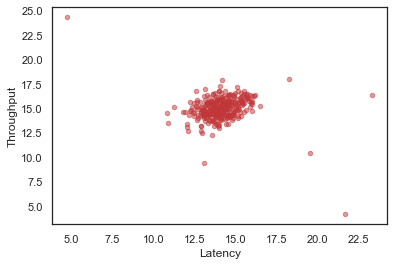

In [5]:
sns.regplot(x = 'Latency', y = 'Throughput',
           data=pd.DataFrame(X, columns=['Latency', 'Throughput']), 
           fit_reg=False,
           scatter_kws={"s":20,
                        "alpha":0.5})
plt.show()

## estimate multivariate Gaussian parameters 𝜇 and 𝜎2

> according to data, X1, and X2 is not independent

In [6]:
mu = X.mean(axis=0)
print(mu, '\n')

cov = np.cov(X.T)
print(cov)

[14.11222578 14.99771051] 

[[ 1.83862041 -0.22786456]
 [-0.22786456  1.71533273]]


In [7]:
# example of creating 2d grid to calculate probability density
np.dstack(np.mgrid[0:3,0:3])

array([[[0, 0],
        [0, 1],
        [0, 2]],

       [[1, 0],
        [1, 1],
        [1, 2]],

       [[2, 0],
        [2, 1],
        [2, 2]]])

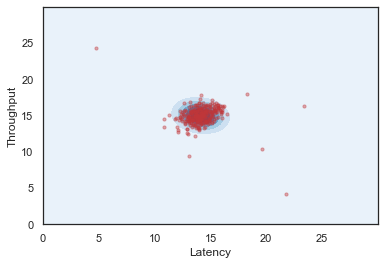

In [8]:
# create multi-var Gaussian model
multi_normal = stats.multivariate_normal(mu, cov)

# create a grid
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots()

# plot probability density
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')

# plot original data points
sns.regplot(x = 'Latency', y = 'Throughput',
           data=pd.DataFrame(X, columns=['Latency', 'Throughput']), 
           fit_reg=False,
           ax=ax,
           scatter_kws={"s":10,
                        "alpha":0.4})
plt.show()

## select threshold 𝜖

In [9]:
def select_threshold(X, Xval, yval):
    """use CV data to find the best epsilon
    Returns:
        e: best epsilon with the highest f-score
        f-score: such best f-score
    """
    # create multivariate model using training data
    mu = X.mean(axis=0)
    cov = np.cov(X.T)
    multi_normal = stats.multivariate_normal(mu, cov)

    # this is key, use CV data for fine tuning hyper parameters
    pval = multi_normal.pdf(Xval)

    # set up epsilon candidates
    epsilon = np.linspace(np.min(pval), np.max(pval), num=10000)

    # calculate f-score
    fs = []
    for e in epsilon:
        y_pred = (pval <= e).astype('int')
        fs.append(f1_score(yval, y_pred))

    # find the best f-score
    argmax_fs = np.argmax(fs)

    return epsilon[argmax_fs], fs[argmax_fs]


In [10]:
from sklearn.metrics import f1_score, classification_report

In [11]:
e, fs = select_threshold(X, Xval, yval)
print('Best epsilon: {}\nBest F-score on validation data: {}'.format(e, fs))

Best epsilon: 3.6135467933531325e-05
Best F-score on validation data: 0.8333333333333333


## visualize prediction of Xval using learned 𝜖


In [12]:
def select_threshold(X, Xval, yval):
    """use CV data to find the best epsilon
    Returns:
        e: best epsilon with the highest f-score
        f-score: such best f-score
    """
    # create multivariate model using training data
    mu = X.mean(axis=0)
    cov = np.cov(X.T)
    multi_normal = stats.multivariate_normal(mu, cov)

    # this is key, use CV data for fine tuning hyper parameters
    pval = multi_normal.pdf(Xval)

    # set up epsilon candidates
    epsilon = np.linspace(np.min(pval), np.max(pval), num=10000)

    # calculate f-score
    fs = []
    for e in epsilon:
        y_pred = (pval <= e).astype('int')
        fs.append(f1_score(yval, y_pred))

    # find the best f-score
    argmax_fs = np.argmax(fs)

    return epsilon[argmax_fs], fs[argmax_fs]


def predict(X, Xval, e, Xtest, ytest):
    """with optimal epsilon, combine X, Xval and predict Xtest
    Returns:
        multi_normal: multivariate normal model
        y_pred: prediction of test data
    """
    Xdata = np.concatenate((X, Xval), axis=0)

    mu = Xdata.mean(axis=0)
    cov = np.cov(Xdata.T)
    multi_normal = stats.multivariate_normal(mu, cov)

    # calculate probability of test data
    pval = multi_normal.pdf(Xtest)
    y_pred = (pval <= e).astype('int')

    print(classification_report(ytest, y_pred))

    return multi_normal, y_pred


In [13]:
multi_normal, y_pred = predict(X, Xval, e, Xtest, ytest)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       152
           1       1.00      1.00      1.00         2

    accuracy                           1.00       154
   macro avg       1.00      1.00      1.00       154
weighted avg       1.00      1.00      1.00       154



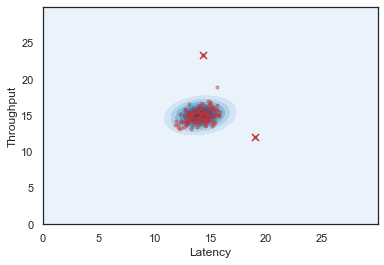

In [14]:
# construct test DataFrame
data = pd.DataFrame(Xtest, columns=['Latency', 'Throughput'])
data['y_pred'] = y_pred

# create a grid for graphing
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots()

# plot probability density
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')

# plot original Xval points
sns.regplot(x = 'Latency', y = 'Throughput',
            data=data,
            fit_reg=False,
            ax=ax,
            scatter_kws={"s":10,
                         "alpha":0.4})

# mark the predicted anamoly of CV data. We should have a test set for this...
anamoly_data = data[data['y_pred']==1]
ax.scatter(anamoly_data['Latency'], anamoly_data['Throughput'], marker='x', s=50)
plt.show()

## high dimension data

In [15]:
mat = scio.loadmat('data/ex8data2.mat')

In [16]:
X = mat.get('X')
Xval, Xtest, yval, ytest = train_test_split(mat.get('Xval'),
                                            mat.get('yval').ravel(),
                                            test_size=0.5)

In [17]:
e, fs = select_threshold(X, Xval, yval)
print('Best epsilon: {}\nBest F-score on validation data: {}'.format(e, fs))

Best epsilon: 8.00530552834364e-20
Best F-score on validation data: 0.7692307692307692


In [18]:
multi_normal, y_pred = predict(X, Xval, e, Xtest, ytest)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        47
           1       0.50      0.33      0.40         3

    accuracy                           0.94        50
   macro avg       0.73      0.66      0.68        50
weighted avg       0.93      0.94      0.93        50



In [19]:
print('find {} anamolies'.format(y_pred.sum()))

find 2 anamolies


# 2-推荐系统

In [20]:
movies_mat = scio.loadmat('data/ex8_movies.mat')
Y, R = movies_mat.get('Y'), movies_mat.get('R')

Y.shape, R.shape

((1682, 943), (1682, 943))

In [21]:
m, u = Y.shape
# m: how many movies
# u: how many users

n = 10  # how many features for a movie

In [22]:
param_mat = scio.loadmat('./data/ex8_movieParams.mat')
theta, X = param_mat.get('Theta'), param_mat.get('X')

theta.shape, X.shape

((943, 10), (1682, 10))

In [23]:
def serialize(X, theta):
    """serialize 2 matrix
    """
    # X (movie, feature), (1682, 10): movie features
    # theta (user, feature), (943, 10): user preference
    return np.concatenate((X.ravel(), theta.ravel()))


def deserialize(param, n_movie, n_user, n_features):
    """into ndarray of X(1682, 10), theta(943, 10)"""
    return param[:n_movie * n_features].reshape(n_movie, n_features), \
           param[n_movie * n_features:].reshape(n_user, n_features)


# recommendation fn
def cost(param, Y, R, n_features):
    """compute cost for every r(i, j)=1
    Args:
        param: serialized X, theta
        Y (movie, user), (1682, 943): (movie, user) rating
        R (movie, user), (1682, 943): (movie, user) has rating
    """
    # theta (user, feature), (943, 10): user preference
    # X (movie, feature), (1682, 10): movie features
    n_movie, n_user = Y.shape
    X, theta = deserialize(param, n_movie, n_user, n_features)

    inner = np.multiply(X @ theta.T - Y, R)

    return np.power(inner, 2).sum() / 2


def gradient(param, Y, R, n_features):
    # theta (user, feature), (943, 10): user preference
    # X (movie, feature), (1682, 10): movie features
    n_movies, n_user = Y.shape
    X, theta = deserialize(param, n_movies, n_user, n_features)

    inner = np.multiply(X @ theta.T - Y, R)  # (1682, 943)

    # X_grad (1682, 10)
    X_grad = inner @ theta

    # theta_grad (943, 10)
    theta_grad = inner.T @ X

    # roll them together and return
    return serialize(X_grad, theta_grad)


def regularized_cost(param, Y, R, n_features, l=1):
    reg_term = np.power(param, 2).sum() * (l / 2)

    return cost(param, Y, R, n_features) + reg_term


def regularized_gradient(param, Y, R, n_features, l=1):
    grad = gradient(param, Y, R, n_features)
    reg_term = l * param

    return grad + reg_term


In [24]:
# use subset of data to calculate the cost as in pdf...
users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
theta_sub = theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

param_sub = serialize(X_sub, theta_sub)
cost(param_sub, Y_sub, R_sub, features)

22.224603725685675

In [25]:
param = serialize(X, theta)  # total real params

cost(serialize(X, theta), Y, R, 10)  # this is real total cost

27918.64012454421

In [26]:
n_movie, n_user = Y.shape

X_grad, theta_grad = deserialize(gradient(param, Y, R, 10),
                                      n_movie, n_user, 10)

In [27]:
assert X_grad.shape == X.shape
assert theta_grad.shape == theta.shape

## regularized cost

In [28]:
# in the ex8_confi.m, lambda = 1.5, and it's using sub data set
regularized_cost(param_sub, Y_sub, R_sub, features, l=1.5)

31.34405624427422

In [29]:
regularized_cost(param, Y, R, 10, l=1)  # total regularized cost

32520.682450229557

## regularized gradient

In [30]:
n_movie, n_user = Y.shape

X_grad, theta_grad = deserialize(regularized_gradient(param, Y, R, 10),
                                                                n_movie, n_user, 10)

assert X_grad.shape == X.shape
assert theta_grad.shape == theta.shape

## parse movie_id.txt

In [31]:
movie_list = []

with open('./data/movie_ids.txt', encoding='latin-1') as f:
    for line in f:
        tokens = line.strip().split(' ')
        movie_list.append(' '.join(tokens[1:]))

movie_list = np.array(movie_list)

## reproduce my ratings

In [32]:
ratings = np.zeros(1682)

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

## prepare data

In [33]:
Y, R = movies_mat.get('Y'), movies_mat.get('R')


Y = np.insert(Y, 0, ratings, axis=1)  # now I become user 0
Y.shape

(1682, 944)

In [34]:
R = np.insert(R, 0, ratings != 0, axis=1)
R.shape

(1682, 944)

In [35]:
n_features = 50
n_movie, n_user = Y.shape
l = 10

In [36]:
X = np.random.standard_normal((n_movie, n_features))
theta = np.random.standard_normal((n_user, n_features))

X.shape, theta.shape

((1682, 50), (944, 50))

In [37]:
param = serialize(X, theta)

In [38]:
Y_norm = Y - Y.mean()  # 这不对吧？ 这难道不是每一行减去每一行的均值？
Y_norm.mean()

4.6862111343939375e-17

## training

In [39]:
import scipy.optimize as opt

In [40]:
res = opt.minimize(fun=regularized_cost,
                   x0=param,
                   args=(Y_norm, R, n_features, l),
                   method='TNC',
                   jac=regularized_gradient)
#这里很慢

In [41]:
res

     fun: 64721.49781507572
     jac: array([ 4.61082705e-08, -1.40007998e-06, -6.49121673e-07, ...,
       -1.31592651e-07,  2.51802587e-07,  7.82384468e-09])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 1976
     nit: 60
  status: 1
 success: True
       x: array([ 0.32800508, -0.10464033, -0.22145959, ..., -0.21000722,
       -0.08625316, -0.57581255])

In [42]:
X_trained, theta_trained = deserialize(res.x, n_movie, n_user, n_features)
X_trained.shape, theta_trained.shape

((1682, 50), (944, 50))

In [43]:
prediction = X_trained @ theta_trained.T

In [44]:
my_preds = prediction[:, 0] + Y.mean()

In [45]:
idx = np.argsort(my_preds)[::-1]  # Descending order
idx.shape

(1682,)

In [46]:
# top ten idx
my_preds[idx][:10]

array([4.12534633, 4.04413418, 3.99324256, 3.91902707, 3.8169077 ,
       3.81555876, 3.76602168, 3.76322557, 3.75903998, 3.75077531])

In [47]:
for m in movie_list[idx][:10]:
    print(m)

Titanic (1997)
Star Wars (1977)
Shawshank Redemption, The (1994)
Forrest Gump (1994)
Raiders of the Lost Ark (1981)
Braveheart (1995)
Return of the Jedi (1983)
Usual Suspects, The (1995)
Godfather, The (1972)
Schindler's List (1993)
